<a href="https://colab.research.google.com/github/Heoyuna0819/machine_learning/blob/main/UCI_CNN%26GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


# 1. 데이터 로드 함수 정의

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = []
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    return np.dstack(loaded)

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix='/content/drive/MyDrive/UCI HAR Dataset/'):
    trainX, trainy = load_dataset_group('train', prefix)
    testX, testy = load_dataset_group('test', prefix)
    trainy, testy = trainy - 1, testy - 1
    trainy_one_hot, testy_one_hot = to_categorical(trainy), to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
# 2. 데이터 준비

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

/tmp/ipython-input-1660725301.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1660725301.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1660725301.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1660725301.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=Tr

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
# 3. 정규화

from sklearn.preprocessing import StandardScaler

X_train_r = X_train.reshape(-1, n_features)
X_val_r   = X_val.reshape(-1, n_features)
testX_r   = testX.reshape(-1, n_features)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_r)
X_val_s   = scaler.transform(X_val_r)
testX_s   = scaler.transform(testX_r)

X_train = X_train_s.reshape(-1, n_timesteps, n_features)
X_val   = X_val_s.reshape(-1, n_timesteps, n_features)
testX   = testX_s.reshape(-1, n_timesteps, n_features)

In [10]:
# 4. CNN + GRU 모델 정의

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # --- CNN 블록 ---
    Conv1D(128, kernel_size=5, activation='relu', input_shape=(n_timesteps, n_features)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(512, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # --- GRU 블록 ---
    GRU(128, return_sequences=False),
    Dropout(0.25),

    # --- Fully Connected ---
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(n_outputs, activation='softmax')
])

# optimizer & compile
optimizer = Adam(learning_rate=0.0002)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 124, 128)       │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 124, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 60, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 28, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 128)            │       246,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 765,574 (2.92 MB)

 Trainable params: 763,782 (2.91 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [11]:
# 5. 콜백 설정 (조기 종료 + LR 조정)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

In [12]:
# 6. 학습
history = model.fit(
    X_train, y_train_one_hot,
    epochs=60,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot),
    callbacks=[es, lr_scheduler],
    verbose=1
)

Epoch 1/60
184/184 ━━━━━━━━━━━━━━━━━━━━ 29s 140ms/step - accuracy: 0.7047 - loss: 0.7816 - val_accuracy: 0.9103 - val_loss: 0.3357 - learning_rate: 2.0000e-04
Epoch 2/60
184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 139ms/step - accuracy: 0.9290 - loss: 0.2020 - val_accuracy: 0.9511 - val_loss: 0.1306 - learning_rate: 2.0000e-04
Epoch 3/60
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - accuracy: 0.9459 - loss: 0.1554 - val_accuracy: 0.9456 - val_loss: 0.1219 - learning_rate: 2.0000e-04
Epoch 4/60
184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 141ms/step - accuracy: 0.9516 - loss: 0.1261 - val_accuracy: 0.9504 - val_loss: 0.1063 - learning_rate: 2.0000e-04
Epoch 5/60
184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 139ms/step - accuracy: 0.9537 - loss: 0.1245 - val_accuracy: 0.9449 - val_loss: 0.1204 - learning_rate: 2.0000e-04
Epoch 6/60
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.9474 - loss: 0.1235 - val_accuracy: 0.9511 - val_loss: 0.1016 - learning_rate: 2.0000e-04
Epoch 7/60
184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 13

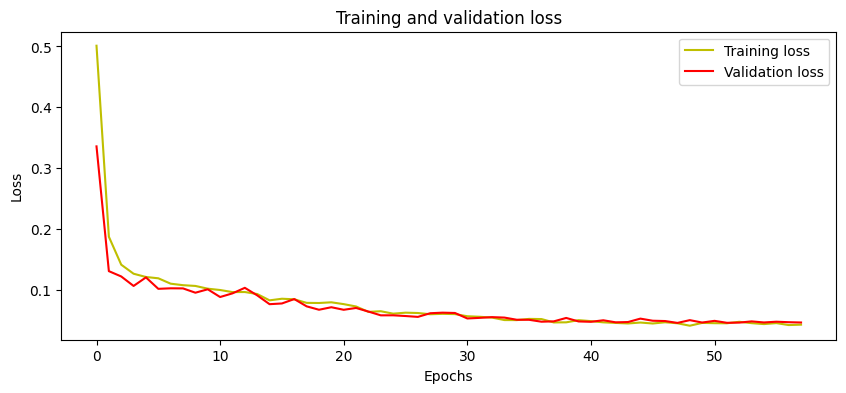

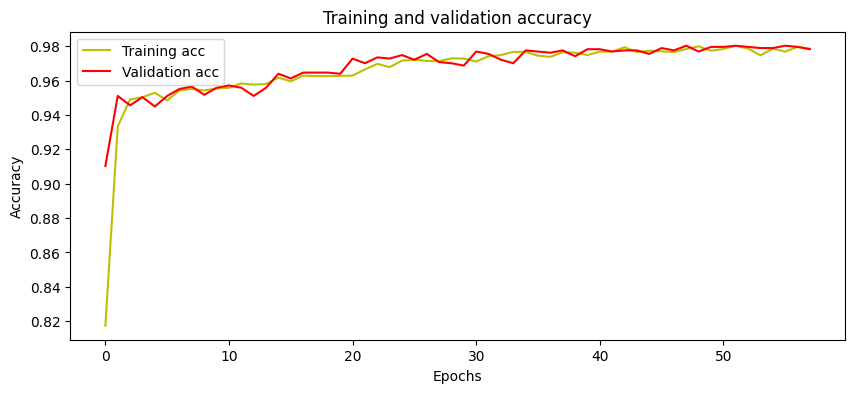

In [13]:
# 7. 학습 곡선 시각화

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], 'y', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], 'y', label='Training acc')
plt.plot(history.history['val_accuracy'], 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
 Accuracy: 0.9199

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       496
           1       0.98      0.96      0.97       471
           2       0.94      1.00      0.97       420
           3       0.80      0.78      0.79       491
           4       0.82      0.82      0.82       532
           5       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



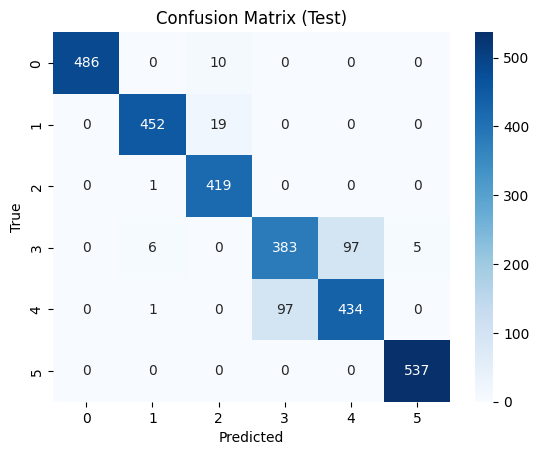

In [14]:
# 8. 테스트 평가 및 혼동행렬

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

pred = model.predict(testX)
pred = np.argmax(pred, axis=-1)
y_true = testy.ravel()

cm = confusion_matrix(y_true, pred)
print(" Accuracy:", round(accuracy_score(y_true, pred), 4))
print("\nClassification Report:\n", classification_report(y_true, pred))

sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test)')
plt.show()